In [2]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

# Paths
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"
test_img_dir = Path("/home/paster/LMY/data/general/split/test/images")
test_mask_dir = Path("/home/paster/LMY/data/general/split/test/mask")

# Load model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
processor = SegformerImageProcessor(do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False)

In [2]:
# Collect image-mask pairs with non-empty masks
pairs = []
for mask_path in sorted(test_mask_dir.glob("*.png")):
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None or np.sum(mask) == 0:
        continue
    image_name = mask_path.name.replace(".png", ".tif")
    image_path = test_img_dir / image_name
    if image_path.exists():
        pairs.append((image_path, mask_path))

print(f"✅ Found {len(pairs)} non-empty test pairs.")



✅ Found 59 non-empty test pairs.


## Visualize a few predictions

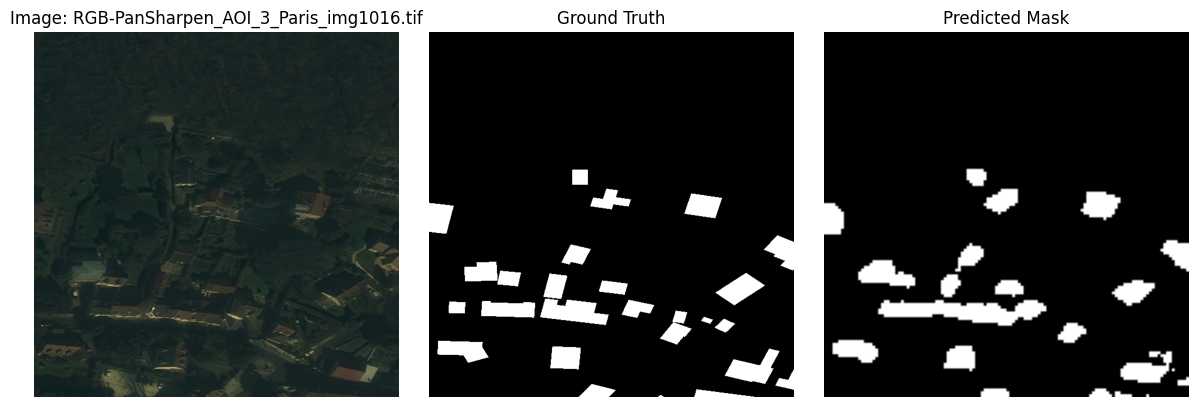

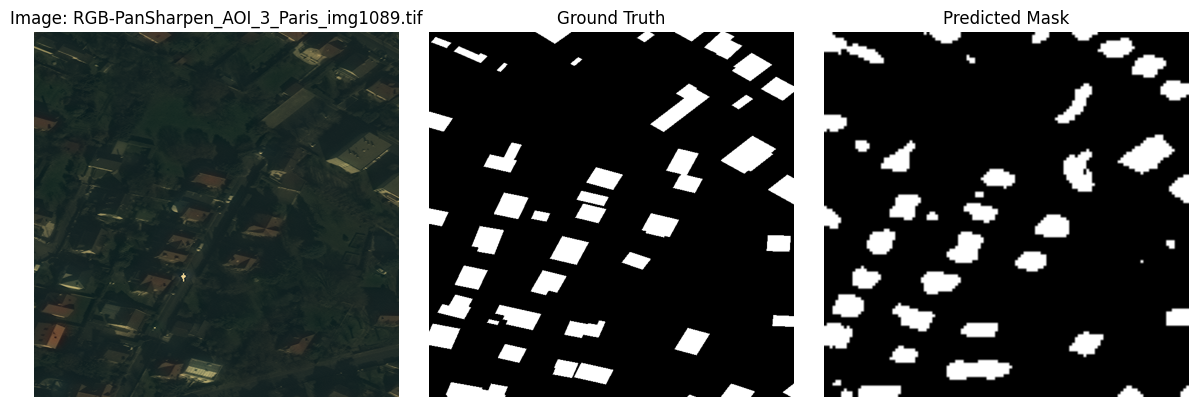

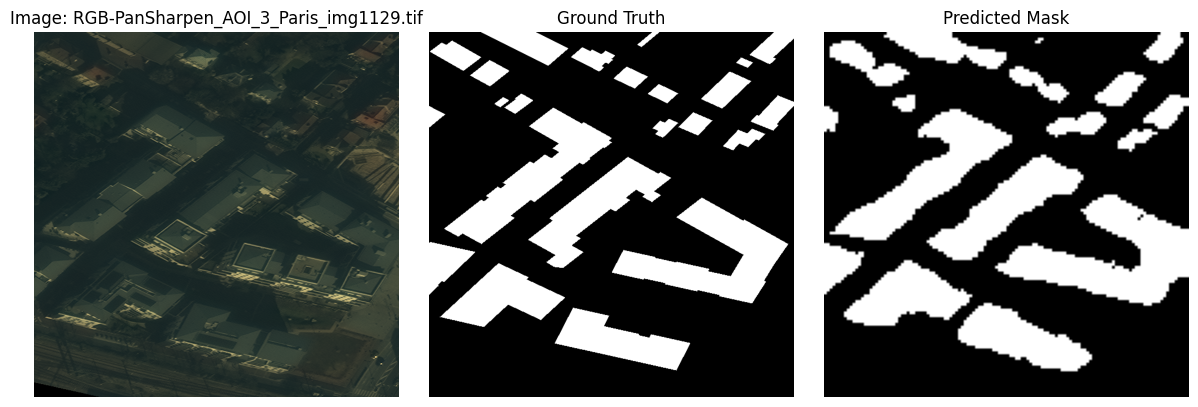

In [3]:
# Predict and visualize a few
n = min(3, len(pairs))
for i in range(n):
    img_path, mask_path = pairs[i]
    
    # Read image with rasterio
    with rasterio.open(img_path) as src:
        image = src.read([1, 2, 3])
        image = np.transpose(image, (1, 2, 0))
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        image_uint8 = (image * 255).astype(np.uint8)
    
    # Process and run model
    inputs = processor(images=image_uint8, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    pred_mask = outputs.logits.argmax(dim=1).squeeze().cpu().numpy()

    # Read ground-truth mask
    gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    # Show side by side
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image: {img_path.name}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## All images

In [4]:
import os
import cv2
import torch
import rasterio
import numpy as np
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# === Paths ===
base_path = Path("/home/paster/LMY/data/general/split")
splits = ["train", "val", "test"]
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"

# === Load model and processor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = SegformerImageProcessor(do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False)
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
model.eval()

# === Evaluation Results ===
results = []

# === Evaluation Loop ===
for split in splits:
    img_dir = base_path / split / "images"
    mask_dir = base_path / split / "mask"

    image_paths = sorted(img_dir.glob("*.tif"))
    y_true_all = []
    y_pred_all = []
    count = 0

    for img_path in image_paths:
        mask_path = mask_dir / img_path.name.replace(".tif", ".png")
        if not mask_path.exists():
            continue
        count += 1

        # Read image
        with rasterio.open(img_path) as src:
            image = src.read([1, 2, 3])
            image = np.transpose(image, (1, 2, 0))
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
            image_uint8 = (image * 255).astype(np.uint8)

        inputs = processor(images=image_uint8, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_mask = logits.argmax(dim=1)[0].cpu().numpy()
            pred_mask_bin = (predicted_mask > 0).astype(np.uint8)

        # Read ground truth
        gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        gt_mask = (gt_mask > 0).astype(np.uint8)

        # Resize to match predicted mask shape
        gt_mask_resized = cv2.resize(gt_mask, (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Flatten and store
        y_true_all.extend(gt_mask_resized.flatten().tolist())
        y_pred_all.extend(pred_mask_bin.flatten().tolist())

    # Compute metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    iou = jaccard_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)

    results.append({
        "split": split,
        "samples": count,
        "accuracy": acc,
        "iou": iou,
        "f1": f1,
        "precision": prec,
        "recall": rec,
    })


In [5]:
for res in results:
    print(f"   Split: {res['split']} | Samples: {res['samples']}")
    print(f"   Accuracy:  {res['accuracy']:.4f}")
    print(f"   IoU:       {res['iou']:.4f}")
    print(f"   F1 Score:  {res['f1']:.4f}")
    print(f"   Precision: {res['precision']:.4f}")
    print(f"   Recall:    {res['recall']:.4f}\n")


   Split: train | Samples: 918
   Accuracy:  0.9775
   IoU:       0.7223
   F1 Score:  0.8388
   Precision: 0.8297
   Recall:    0.8481

   Split: val | Samples: 114
   Accuracy:  0.9714
   IoU:       0.6953
   F1 Score:  0.8203
   Precision: 0.8040
   Recall:    0.8372

   Split: test | Samples: 116
   Accuracy:  0.9766
   IoU:       0.6805
   F1 Score:  0.8099
   Precision: 0.7983
   Recall:    0.8218



## Images with buildings only

In [6]:
import os
import cv2
import torch
import rasterio
import numpy as np
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# === Paths ===
base_path = Path("/home/paster/LMY/data/general/split")
splits = ["train", "val", "test"]
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"

# === Load model and processor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = SegformerImageProcessor(do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False)
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
model.eval()

# === Evaluation Results ===
results = []

# === Evaluation Loop ===
for split in splits:
    img_dir = base_path / split / "images"
    mask_dir = base_path / split / "mask"

    image_paths = sorted(img_dir.glob("*.tif"))
    y_true_all = []
    y_pred_all = []
    count = 0

    for img_path in image_paths:
        mask_path = mask_dir / img_path.name.replace(".tif", ".png")
        if not mask_path.exists():
            continue

        # Read ground truth mask first to filter
        gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if gt_mask is None or np.sum(gt_mask) == 0:
            continue  # Skip empty masks (no buildings)

        count += 1

        # Read image
        with rasterio.open(img_path) as src:
            image = src.read([1, 2, 3])
            image = np.transpose(image, (1, 2, 0))
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
            image_uint8 = (image * 255).astype(np.uint8)

        inputs = processor(images=image_uint8, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_mask = logits.argmax(dim=1)[0].cpu().numpy()
            pred_mask_bin = (predicted_mask > 0).astype(np.uint8)

        gt_mask = (gt_mask > 0).astype(np.uint8)
        gt_mask_resized = cv2.resize(gt_mask, (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        y_true_all.extend(gt_mask_resized.flatten().tolist())
        y_pred_all.extend(pred_mask_bin.flatten().tolist())

    # Compute metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    iou = jaccard_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)

    results.append({
        "split": split,
        "samples": count,
        "accuracy": acc,
        "iou": iou,
        "f1": f1,
        "precision": prec,
        "recall": rec,
    })

# Print results
for r in results:
    print(f"Split: {r['split']} | Samples: {r['samples']}")
    print(f"  Accuracy:  {r['accuracy']:.4f}")
    print(f"  IoU:       {r['iou']:.4f}")
    print(f"  F1 Score:  {r['f1']:.4f}")
    print(f"  Precision: {r['precision']:.4f}")
    print(f"  Recall:    {r['recall']:.4f}")
    print()


Split: train | Samples: 508
  Accuracy:  0.9593
  IoU:       0.7223
  F1 Score:  0.8388
  Precision: 0.8297
  Recall:    0.8481

Split: val | Samples: 66
  Accuracy:  0.9512
  IoU:       0.6977
  F1 Score:  0.8220
  Precision: 0.8072
  Recall:    0.8372

Split: test | Samples: 59
  Accuracy:  0.9543
  IoU:       0.6816
  F1 Score:  0.8107
  Precision: 0.7998
  Recall:    0.8218



## Images with buildings only

In [8]:
import os
import cv2
import torch
import rasterio
import numpy as np
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# === Paths ===
base_path = Path("/home/paster/LMY/data/general/split")
splits = ["train", "val", "test"]
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"

# === Load model and processor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = SegformerImageProcessor(do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False)
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
model.eval()

# === Evaluation Results ===
results = []

# === Evaluation Loop ===
for split in splits:
    img_dir = base_path / split / "images"
    mask_dir = base_path / split / "mask"

    image_paths = sorted(img_dir.glob("*.tif"))
    y_true_all = []
    y_pred_all = []
    count = 0

    for img_path in image_paths:
        mask_path = mask_dir / img_path.name.replace(".tif", ".png")
        if not mask_path.exists():
            continue

        # Read ground truth to check if there's any building (positive class)
        gt_mask_check = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if gt_mask_check is None or np.sum(gt_mask_check) == 0:
            continue  # skip background-only images

        count += 1

        # Read image
        with rasterio.open(img_path) as src:
            image = src.read([1, 2, 3])
            image = np.transpose(image, (1, 2, 0))
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
            image_uint8 = (image * 255).astype(np.uint8)

        inputs = processor(images=image_uint8, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_mask = logits.argmax(dim=1)[0].cpu().numpy()
            pred_mask_bin = (predicted_mask > 0).astype(np.uint8)

        # Read and binarize ground truth
        gt_mask = (gt_mask_check > 0).astype(np.uint8)

        # Resize to match predicted mask shape
        gt_mask_resized = cv2.resize(gt_mask, (pred_mask_bin.shape[1], pred_mask_bin.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Flatten and store
        y_true_all.extend(gt_mask_resized.flatten().tolist())
        y_pred_all.extend(pred_mask_bin.flatten().tolist())

    # Compute metrics
    acc = accuracy_score(y_true_all, y_pred_all)  # Same as pixel accuracy
    iou = jaccard_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)

    results.append({
        "split": split,
        "samples": count,
        "pixel_accuracy": acc,
        "iou": iou,
        "f1": f1,
        "precision": prec,
        "recall": rec,
    })

# Print results
for r in results:
    print(f"\nSplit: {r['split']} | Samples: {r['samples']}")
    print(f"  Pixel Accuracy: {r['pixel_accuracy']:.4f}")
    print(f"  IoU:            {r['iou']:.4f}")
    print(f"  F1 Score:       {r['f1']:.4f}")
    print(f"  Precision:      {r['precision']:.4f}")
    print(f"  Recall:         {r['recall']:.4f}")



Split: train | Samples: 508
  Pixel Accuracy: 0.9593
  IoU:            0.7223
  F1 Score:       0.8388
  Precision:      0.8297
  Recall:         0.8481

Split: val | Samples: 66
  Pixel Accuracy: 0.9512
  IoU:            0.6977
  F1 Score:       0.8220
  Precision:      0.8072
  Recall:         0.8372

Split: test | Samples: 59
  Pixel Accuracy: 0.9543
  IoU:            0.6816
  F1 Score:       0.8107
  Precision:      0.7998
  Recall:         0.8218


Computes IoU per image

Selects 5 best and 5 worst IoU examples

Displays side-by-side original image, ground truth mask, and predicted mask using matplotlib subplots

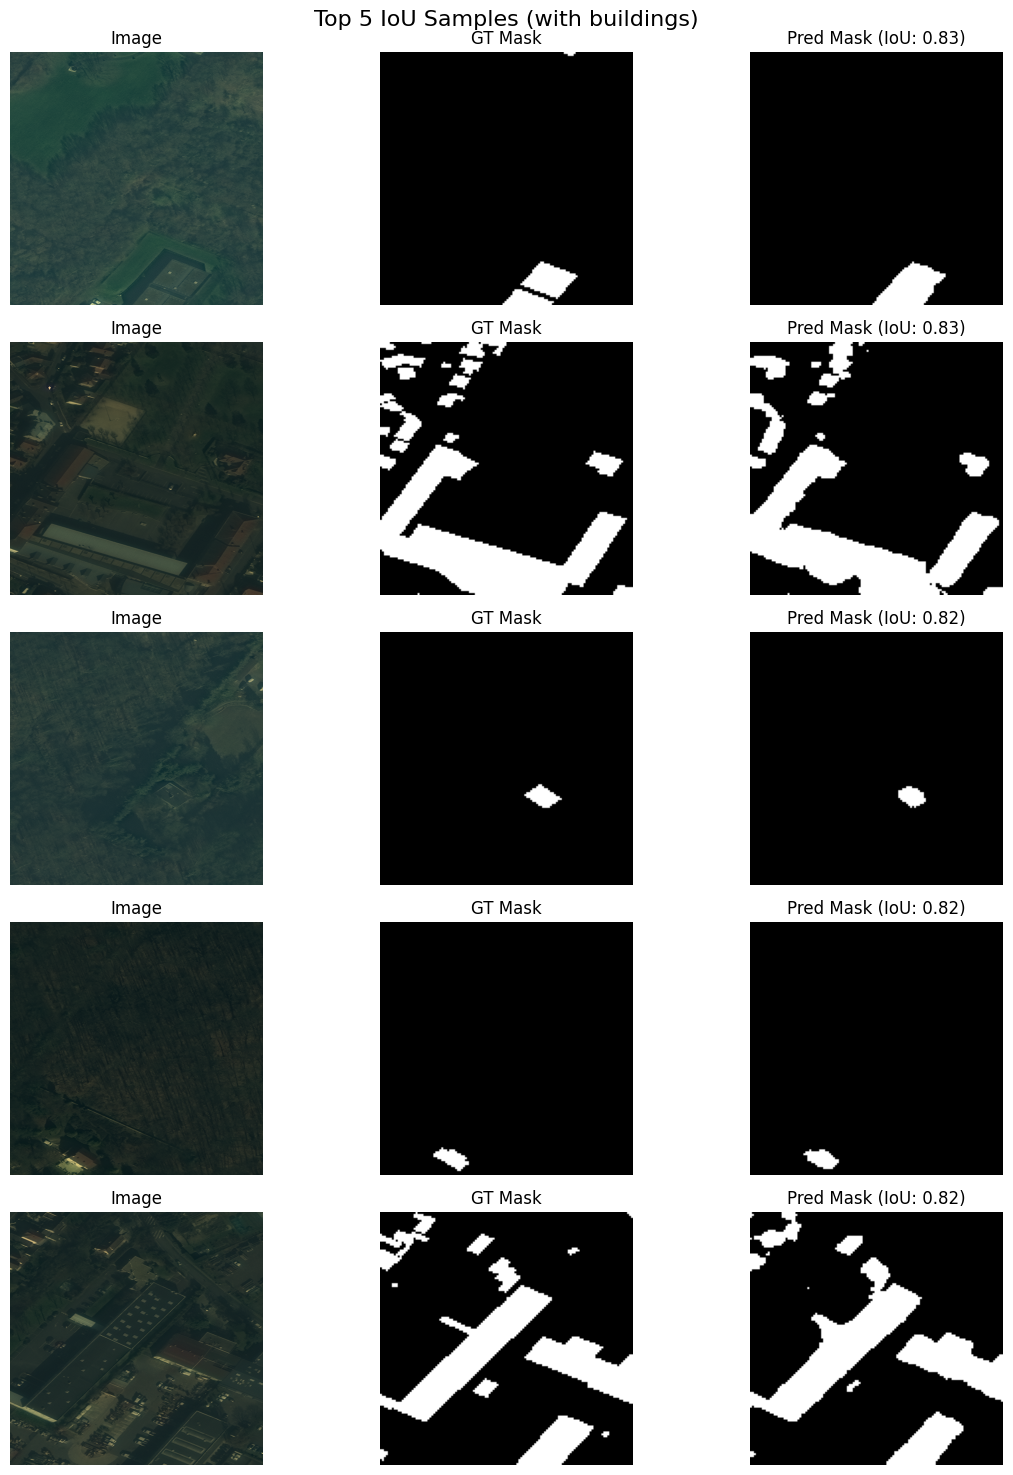

In [3]:
import os
import cv2
import torch
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import jaccard_score
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# === Paths ===
base_path = Path("/home/paster/LMY/data/general/split")
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"
split = "val"  # Visualize on validation set

# === Load model and processor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = SegformerImageProcessor(
    do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False
)
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
model.eval()

# === Evaluation Loop ===
img_dir = base_path / split / "images"
mask_dir = base_path / split / "mask"
image_paths = sorted(img_dir.glob("*.tif"))

samples = []

for img_path in image_paths:
    mask_path = mask_dir / img_path.name.replace(".tif", ".png")
    if not mask_path.exists():
        continue

    # Read and normalize image
    with rasterio.open(img_path) as src:
        image = src.read([1, 2, 3])
        image = np.transpose(image, (1, 2, 0))
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        image_uint8 = (image * 255).astype(np.uint8)

    inputs = processor(images=image_uint8, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_mask = logits.argmax(dim=1)[0].cpu().numpy()
        pred_mask_bin = (predicted_mask > 0).astype(np.uint8)

    # Load and prepare ground truth
    gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    gt_mask = (gt_mask > 0).astype(np.uint8)
    gt_mask_resized = cv2.resize(gt_mask, (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Compute IoU
    if (gt_mask_resized.sum() == 0) and (pred_mask_bin.sum() == 0):
        iou = 1.0
    else:
        iou = jaccard_score(gt_mask_resized.flatten(), pred_mask_bin.flatten(), zero_division=1)

    samples.append({
        "path": img_path,
        "image": image_uint8,
        "gt": gt_mask_resized,
        "pred": pred_mask_bin,
        "iou": iou
    })

# === Filter samples that have buildings in GT ===
samples_with_buildings = [s for s in samples if s["gt"].sum() > 0]

# === Sort by IoU and pick top 5 ===
best_building_samples = sorted(samples_with_buildings, key=lambda x: x["iou"], reverse=True)[:5]

# === Plotting Function ===
def plot_samples(title, samples):
    fig, axs = plt.subplots(len(samples), 3, figsize=(12, len(samples) * 3))
    fig.suptitle(title, fontsize=16)
    for i, s in enumerate(samples):
        axs[i, 0].imshow(s["image"])
        axs[i, 0].set_title("Image")
        axs[i, 1].imshow(s["gt"], cmap='gray')
        axs[i, 1].set_title("GT Mask")
        axs[i, 2].imshow(s["pred"], cmap='gray')
        axs[i, 2].set_title(f"Pred Mask (IoU: {s['iou']:.2f})")
        for ax in axs[i]:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

# === Visualize ===
plot_samples("Top 5 IoU Samples (with buildings)", best_building_samples)


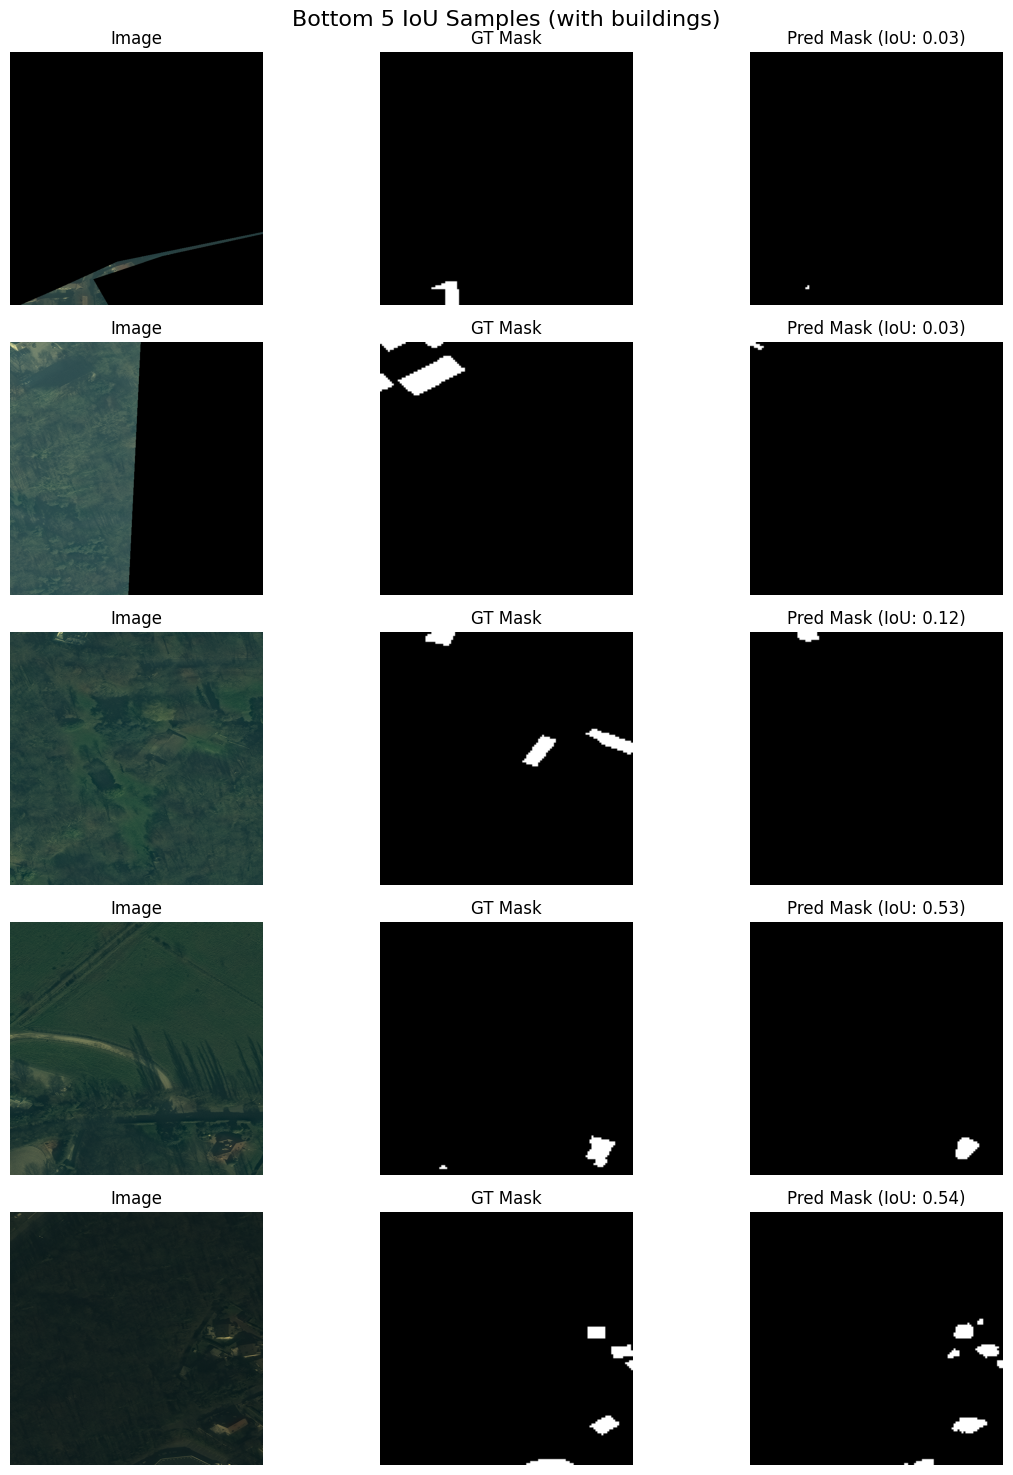

In [4]:
import os
import cv2
import torch
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import jaccard_score
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# === Paths ===
base_path = Path("/home/paster/LMY/data/general/split")
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"
split = "val"  # Visualize on validation set

# === Load model and processor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = SegformerImageProcessor(
    do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False
)
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
model.eval()

# === Evaluation Loop ===
img_dir = base_path / split / "images"
mask_dir = base_path / split / "mask"
image_paths = sorted(img_dir.glob("*.tif"))

samples = []

for img_path in image_paths:
    mask_path = mask_dir / img_path.name.replace(".tif", ".png")
    if not mask_path.exists():
        continue

    # Read and normalize image
    with rasterio.open(img_path) as src:
        image = src.read([1, 2, 3])
        image = np.transpose(image, (1, 2, 0))
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        image_uint8 = (image * 255).astype(np.uint8)

    inputs = processor(images=image_uint8, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_mask = logits.argmax(dim=1)[0].cpu().numpy()
        pred_mask_bin = (predicted_mask > 0).astype(np.uint8)

    # Load and prepare ground truth
    gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    gt_mask = (gt_mask > 0).astype(np.uint8)
    gt_mask_resized = cv2.resize(gt_mask, (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Compute IoU
    if (gt_mask_resized.sum() == 0) and (pred_mask_bin.sum() == 0):
        iou = 1.0
    else:
        iou = jaccard_score(gt_mask_resized.flatten(), pred_mask_bin.flatten(), zero_division=1)

    samples.append({
        "path": img_path,
        "image": image_uint8,
        "gt": gt_mask_resized,
        "pred": pred_mask_bin,
        "iou": iou
    })

# === Filter samples that have buildings in GT ===
samples_with_buildings = [s for s in samples if s["gt"].sum() > 0]

# === Sort by IoU ascending and pick bottom 5 ===
worst_building_samples = sorted(samples_with_buildings, key=lambda x: x["iou"])[:5]

# === Plotting Function ===
def plot_samples(title, samples):
    fig, axs = plt.subplots(len(samples), 3, figsize=(12, len(samples) * 3))
    fig.suptitle(title, fontsize=16)
    for i, s in enumerate(samples):
        axs[i, 0].imshow(s["image"])
        axs[i, 0].set_title("Image")
        axs[i, 1].imshow(s["gt"], cmap='gray')
        axs[i, 1].set_title("GT Mask")
        axs[i, 2].imshow(s["pred"], cmap='gray')
        axs[i, 2].set_title(f"Pred Mask (IoU: {s['iou']:.2f})")
        for ax in axs[i]:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

# === Visualize ===
plot_samples("Bottom 5 IoU Samples (with buildings)", worst_building_samples)


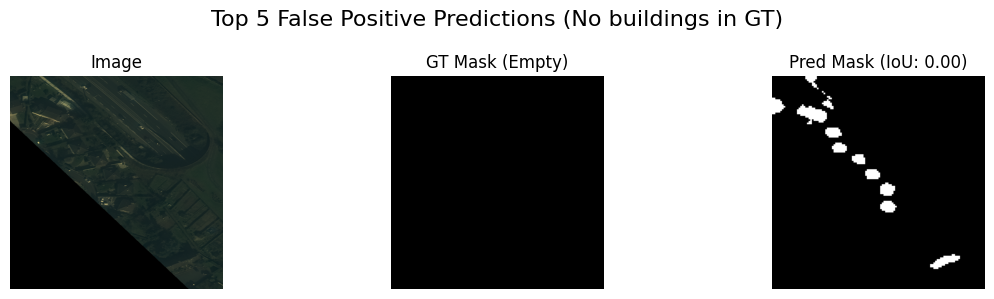

In [7]:
import os
import cv2
import torch
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import jaccard_score
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# === Paths ===
base_path = Path("/home/paster/LMY/data/general/split")
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"
split = "val"  # Visualize on validation set

# === Load model and processor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = SegformerImageProcessor(
    do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False
)
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
model.eval()

# === Evaluation Loop ===
img_dir = base_path / split / "images"
mask_dir = base_path / split / "mask"
image_paths = sorted(img_dir.glob("*.tif"))

samples = []

for img_path in image_paths:
    mask_path = mask_dir / img_path.name.replace(".tif", ".png")
    if not mask_path.exists():
        continue

    # Read and normalize image
    with rasterio.open(img_path) as src:
        image = src.read([1, 2, 3])
        image = np.transpose(image, (1, 2, 0))
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        image_uint8 = (image * 255).astype(np.uint8)

    inputs = processor(images=image_uint8, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_mask = logits.argmax(dim=1)[0].cpu().numpy()
        pred_mask_bin = (predicted_mask > 0).astype(np.uint8)

    # Load and prepare ground truth
    gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    gt_mask = (gt_mask > 0).astype(np.uint8)
    gt_mask_resized = cv2.resize(gt_mask, (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Compute IoU
    if (gt_mask_resized.sum() == 0) and (pred_mask_bin.sum() == 0):
        iou = 1.0  # both empty
    else:
        iou = jaccard_score(gt_mask_resized.flatten(), pred_mask_bin.flatten(), zero_division=1)

    samples.append({
        "path": img_path,
        "image": image_uint8,
        "gt": gt_mask_resized,
        "pred": pred_mask_bin,
        "iou": iou
    })

# === Filter: GT is empty (no buildings), prediction is NOT empty (false positive)
false_positive_samples = [
    s for s in samples
    if s["gt"].sum() == 0 and s["pred"].sum() > 0 and s["iou"] < 1.0
]

# === Sort by IoU ascending and pick 5 worst
worst_fp_samples = sorted(false_positive_samples, key=lambda x: x["iou"])[:5]

# === Plotting Function
def plot_samples(title, samples):
    import matplotlib.pyplot as plt

    num_samples = len(samples)
    fig, axs = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
    fig.suptitle(title, fontsize=16)

    # Ensure axs is always 2D
    if num_samples == 1:
        axs = np.expand_dims(axs, axis=0)

    for i, s in enumerate(samples):
        axs[i][0].imshow(s["image"])
        axs[i][0].set_title("Image")

        axs[i][1].imshow(s["gt"], cmap='gray')
        axs[i][1].set_title("GT Mask (Empty)")

        axs[i][2].imshow(s["pred"], cmap='gray')
        axs[i][2].set_title(f"Pred Mask (IoU: {s['iou']:.2f})")

        for ax in axs[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


# === Visualize
plot_samples("Top 5 False Positive Predictions (No buildings in GT)", worst_fp_samples)


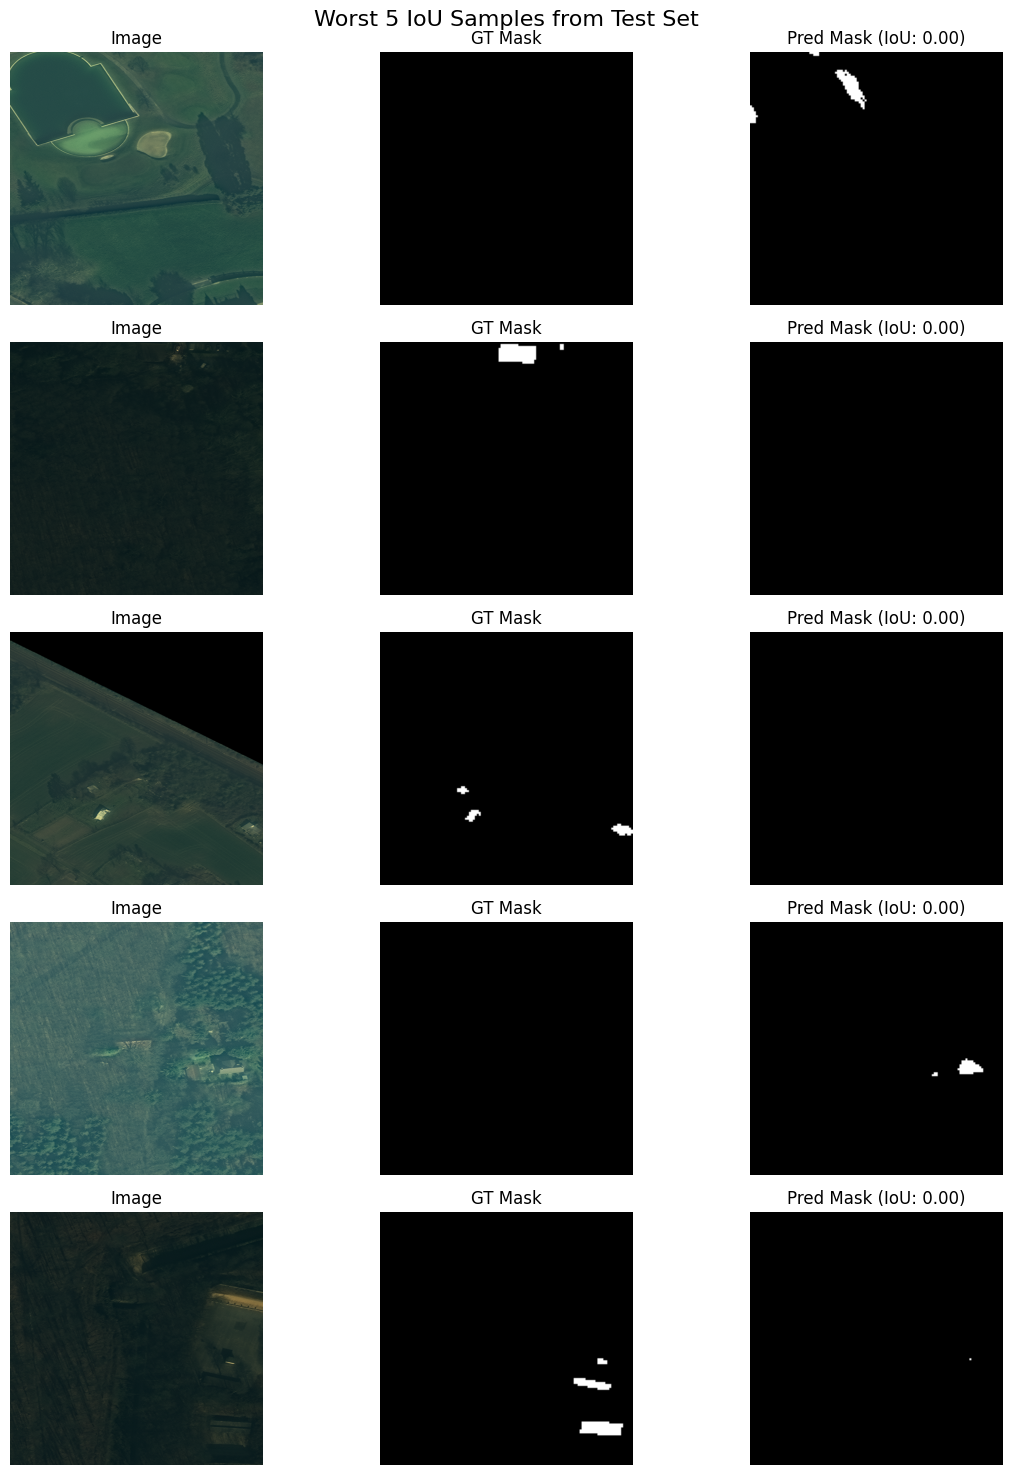

In [8]:
import os
import cv2
import torch
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import jaccard_score
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# === Paths ===
base_path = Path("/home/paster/LMY/data/general/split")
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"
split = "test"  # now evaluating entire test set

# === Load model and processor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = SegformerImageProcessor(
    do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False
)
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
model.eval()

# === Evaluation Loop ===
img_dir = base_path / split / "images"
mask_dir = base_path / split / "mask"
image_paths = sorted(img_dir.glob("*.tif"))

samples = []

for img_path in image_paths:
    mask_path = mask_dir / img_path.name.replace(".tif", ".png")
    if not mask_path.exists():
        continue

    # Read and normalize image
    with rasterio.open(img_path) as src:
        image = src.read([1, 2, 3])
        image = np.transpose(image, (1, 2, 0))
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        image_uint8 = (image * 255).astype(np.uint8)

    inputs = processor(images=image_uint8, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_mask = logits.argmax(dim=1)[0].cpu().numpy()
        pred_mask_bin = (predicted_mask > 0).astype(np.uint8)

    # Load and prepare ground truth
    gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    gt_mask = (gt_mask > 0).astype(np.uint8)
    gt_mask_resized = cv2.resize(gt_mask, (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Compute IoU
    if (gt_mask_resized.sum() == 0) and (pred_mask_bin.sum() == 0):
        iou = 1.0  # both empty, perfect match
    else:
        iou = jaccard_score(gt_mask_resized.flatten(), pred_mask_bin.flatten(), zero_division=1)

    samples.append({
        "path": img_path,
        "image": image_uint8,
        "gt": gt_mask_resized,
        "pred": pred_mask_bin,
        "iou": iou
    })

# === Sort by IoU and take bottom 5
worst_samples = sorted(samples, key=lambda x: x["iou"])[:5]

# === Plotting Function
def plot_samples(title, samples):
    fig, axs = plt.subplots(len(samples), 3, figsize=(12, len(samples) * 3))
    fig.suptitle(title, fontsize=16)

    if len(samples) == 1:
        axs = np.expand_dims(axs, axis=0)

    for i, s in enumerate(samples):
        axs[i][0].imshow(s["image"])
        axs[i][0].set_title("Image")

        axs[i][1].imshow(s["gt"], cmap='gray')
        axs[i][1].set_title("GT Mask")

        axs[i][2].imshow(s["pred"], cmap='gray')
        axs[i][2].set_title(f"Pred Mask (IoU: {s['iou']:.2f})")

        for ax in axs[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# === Show worst 5
plot_samples("Worst 5 IoU Samples from Test Set", worst_samples)


IoU statistics for all images 

Processing split: train
Processing split: val
Processing split: test

=== IoU Statistics Per Split ===

TRAIN
Samples: 918
Min IoU: 0.0000
Max IoU: 1.0000
Mean IoU: 0.8155
Median IoU: 0.8011
Std Dev: 0.2110

VAL
Samples: 114
Min IoU: 0.0000
Max IoU: 1.0000
Mean IoU: 0.7978
Median IoU: 0.7559
Std Dev: 0.2130

TEST
Samples: 116
Min IoU: 0.0000
Max IoU: 1.0000
Mean IoU: 0.7953
Median IoU: 0.8535
Std Dev: 0.2537


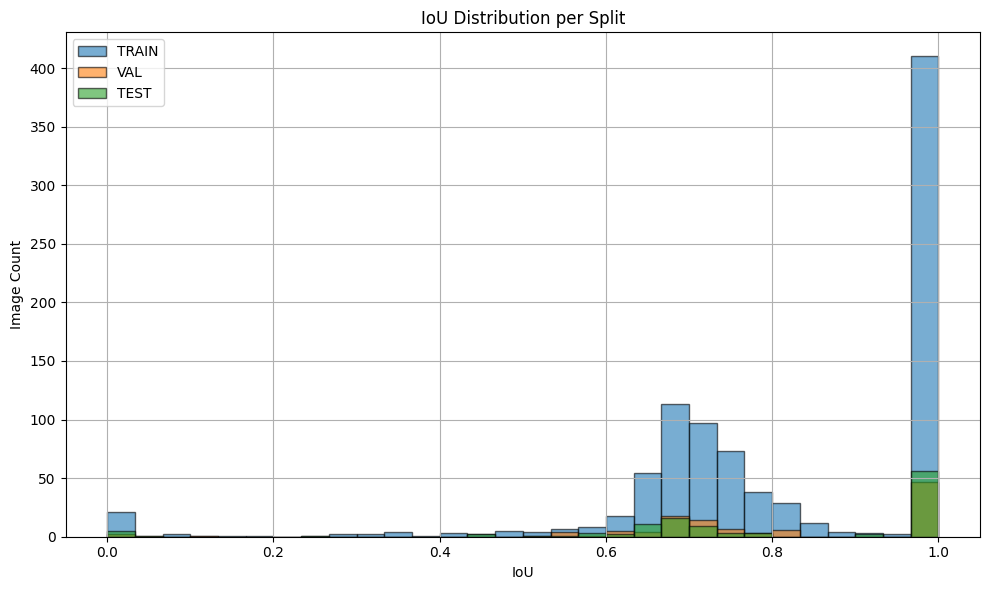

In [9]:
import os
import cv2
import torch
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import jaccard_score
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# === Paths ===
base_path = Path("/home/paster/LMY/data/general/split")
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"
splits = ["train", "val", "test"]

# === Load model and processor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = SegformerImageProcessor(
    do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False
)
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
model.eval()

# === Store IoUs for each split
iou_stats = {}

# === Evaluation Loop Per Split
for split in splits:
    print(f"Processing split: {split}")
    img_dir = base_path / split / "images"
    mask_dir = base_path / split / "mask"
    image_paths = sorted(img_dir.glob("*.tif"))

    split_ious = []

    for img_path in image_paths:
        mask_path = mask_dir / img_path.name.replace(".tif", ".png")
        if not mask_path.exists():
            continue

        # Read image
        with rasterio.open(img_path) as src:
            image = src.read([1, 2, 3])
            image = np.transpose(image, (1, 2, 0))
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
            image_uint8 = (image * 255).astype(np.uint8)

        inputs = processor(images=image_uint8, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_mask = logits.argmax(dim=1)[0].cpu().numpy()
            pred_mask_bin = (predicted_mask > 0).astype(np.uint8)

        # Ground truth
        gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        gt_mask = (gt_mask > 0).astype(np.uint8)
        gt_mask_resized = cv2.resize(gt_mask, (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        # IoU
        if (gt_mask_resized.sum() == 0) and (pred_mask_bin.sum() == 0):
            iou = 1.0
        else:
            iou = jaccard_score(gt_mask_resized.flatten(), pred_mask_bin.flatten(), zero_division=1)

        split_ious.append(iou)

    # Save stats
    iou_stats[split] = {
        "ious": split_ious,
        "min": np.min(split_ious),
        "max": np.max(split_ious),
        "mean": np.mean(split_ious),
        "median": np.median(split_ious),
        "std": np.std(split_ious)
    }

# === Print stats
print("\n=== IoU Statistics Per Split ===")
for split in splits:
    stats = iou_stats[split]
    print(f"\n{split.upper()}")
    print(f"Samples: {len(stats['ious'])}")
    print(f"Min IoU: {stats['min']:.4f}")
    print(f"Max IoU: {stats['max']:.4f}")
    print(f"Mean IoU: {stats['mean']:.4f}")
    print(f"Median IoU: {stats['median']:.4f}")
    print(f"Std Dev: {stats['std']:.4f}")

# === Plot IoU Distributions
plt.figure(figsize=(10, 6))
for split in splits:
    plt.hist(iou_stats[split]["ious"], bins=30, alpha=0.6, label=split.upper(), edgecolor='black')

plt.xlabel("IoU")
plt.ylabel("Image Count")
plt.title("IoU Distribution per Split")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


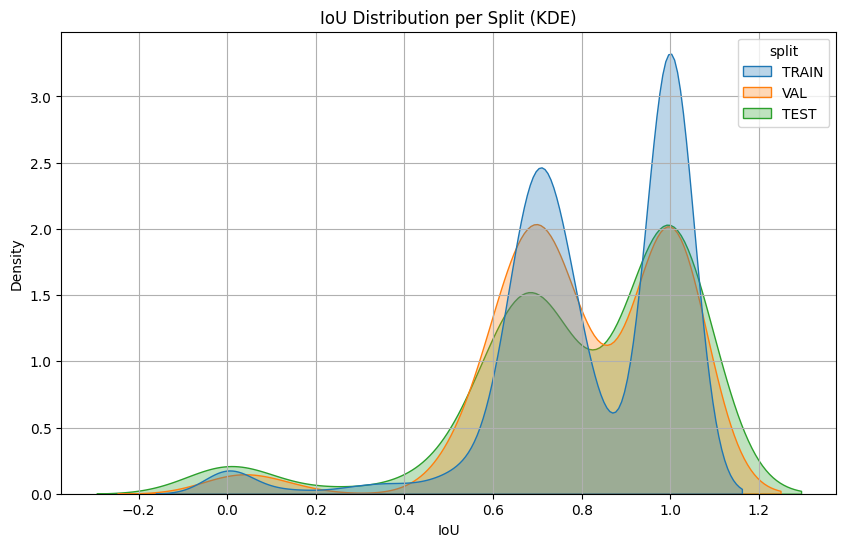

In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# === Flatten to long-form DataFrame for seaborn
plot_data = []
for split in splits:
    for val in iou_stats[split]["ious"]:
        plot_data.append({"split": split.upper(), "IoU": val})

df = pd.DataFrame(plot_data)

# === KDE Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="IoU", hue="split", fill=True, common_norm=False, alpha=0.3)
plt.title("IoU Distribution per Split (KDE)")
plt.xlabel("IoU")
plt.ylabel("Density")
plt.grid(True)
plt.show()


IoU statistics for images with buildings in GT  only

Processing split: train
Processing split: val
Processing split: test

=== IoU Statistics (Only Images with Buildings in GT) ===

TRAIN - 508 images with buildings
Min IoU:    0.0000
Max IoU:    0.9558
Mean IoU:   0.6665
Median IoU: 0.7019
Std Dev:    0.1754

VAL - 66 images with buildings
Min IoU:    0.0319
Max IoU:    0.8323
Mean IoU:   0.6659
Median IoU: 0.6858
Std Dev:    0.1492

TEST - 59 images with buildings
Min IoU:    0.0000
Max IoU:    1.0000
Mean IoU:   0.6314
Median IoU: 0.6720
Std Dev:    0.1979


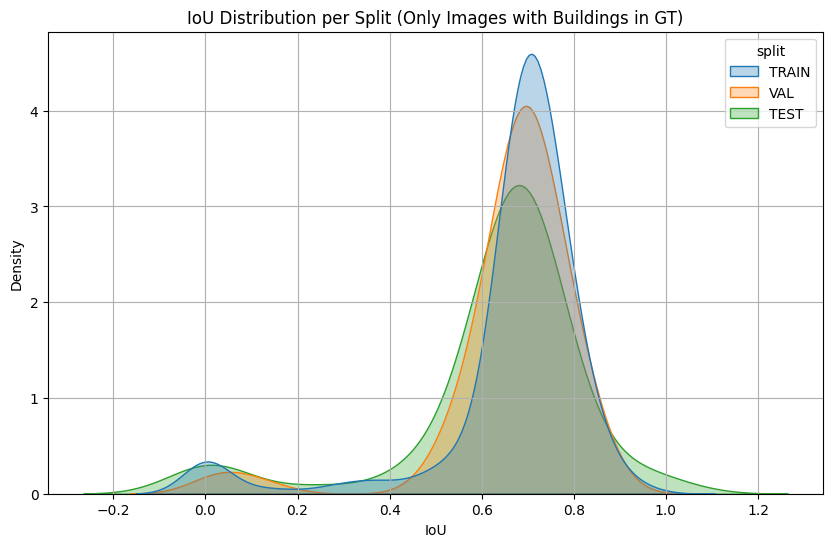

In [14]:
import os
import cv2
import torch
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from sklearn.metrics import jaccard_score
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# === Paths ===
base_path = Path("/home/paster/LMY/data/general/split")
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"
splits = ["train", "val", "test"]

# === Load model and processor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = SegformerImageProcessor(
    do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False
)
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
model.eval()

# === Store per-split IoUs (only with buildings)
iou_stats = {}
plot_data = []  # for KDE plot

for split in splits:
    print(f"Processing split: {split}")
    img_dir = base_path / split / "images"
    mask_dir = base_path / split / "mask"
    image_paths = sorted(img_dir.glob("*.tif"))

    split_ious_with_buildings = []

    for img_path in image_paths:
        mask_path = mask_dir / img_path.name.replace(".tif", ".png")
        if not mask_path.exists():
            continue

        # Read and normalize image
        with rasterio.open(img_path) as src:
            image = src.read([1, 2, 3])
            image = np.transpose(image, (1, 2, 0))
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
            image_uint8 = (image * 255).astype(np.uint8)

        inputs = processor(images=image_uint8, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_mask = logits.argmax(dim=1)[0].cpu().numpy()
            pred_mask_bin = (predicted_mask > 0).astype(np.uint8)

        # Load and prepare ground truth
        gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        gt_mask = (gt_mask > 0).astype(np.uint8)
        gt_mask_resized = cv2.resize(gt_mask, (pred_mask_bin.shape[1], pred_mask_bin.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Skip if no buildings in GT
        if gt_mask_resized.sum() == 0:
            continue

        # Compute IoU
        iou = jaccard_score(gt_mask_resized.flatten(), pred_mask_bin.flatten(), zero_division=1)

        split_ious_with_buildings.append(iou)
        plot_data.append({"split": split.upper(), "iou": iou})

    # Save stats for split
    iou_stats[split] = {
        "ious": split_ious_with_buildings,
        "min": np.min(split_ious_with_buildings) if split_ious_with_buildings else None,
        "max": np.max(split_ious_with_buildings) if split_ious_with_buildings else None,
        "mean": np.mean(split_ious_with_buildings) if split_ious_with_buildings else None,
        "median": np.median(split_ious_with_buildings) if split_ious_with_buildings else None,
        "std": np.std(split_ious_with_buildings) if split_ious_with_buildings else None,
        "count": len(split_ious_with_buildings)
    }

# === Print stats
print("\n=== IoU Statistics (Only Images with Buildings in GT) ===")
for split in splits:
    stats = iou_stats[split]
    print(f"\n{split.upper()} - {stats['count']} images with buildings")
    print(f"Min IoU:    {stats['min']:.4f}" if stats['min'] is not None else "No building samples")
    print(f"Max IoU:    {stats['max']:.4f}" if stats['max'] is not None else "")
    print(f"Mean IoU:   {stats['mean']:.4f}" if stats['mean'] is not None else "")
    print(f"Median IoU: {stats['median']:.4f}" if stats['median'] is not None else "")
    print(f"Std Dev:    {stats['std']:.4f}" if stats['std'] is not None else "")

# === KDE Plot
df = pd.DataFrame(plot_data)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="iou", hue="split", fill=True, common_norm=False, alpha=0.3)
plt.title("IoU Distribution per Split (Only Images with Buildings in GT)")
plt.xlabel("IoU")
plt.ylabel("Density")
plt.grid(True)
plt.show()


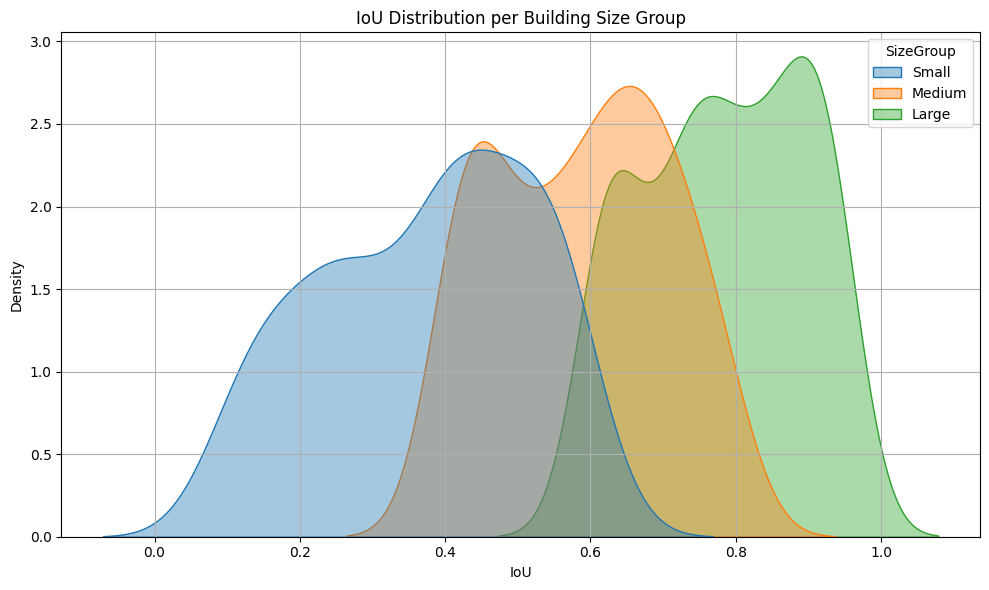

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Simulated data — replace this with your actual building IoU and area stats
np.random.seed(42)
gt_areas = np.concatenate([
    np.random.randint(50, 300, 100),     # Small buildings
    np.random.randint(500, 3000, 100),   # Medium buildings
    np.random.randint(5000, 20000, 100)  # Large buildings
])
ious = np.concatenate([
    np.random.uniform(0.1, 0.6, 100),   # Small
    np.random.uniform(0.4, 0.8, 100),   # Medium
    np.random.uniform(0.6, 0.95, 100)   # Large
])

df = pd.DataFrame({
    "GT_area": gt_areas,
    "IoU": ious
})

# Clean and type-safe conversion
df = df.dropna(subset=["GT_area", "IoU"])
df["GT_area"] = pd.to_numeric(df["GT_area"], errors="coerce")
df["IoU"] = pd.to_numeric(df["IoU"], errors="coerce")
df = df.dropna(subset=["GT_area", "IoU"])

# Categorize buildings by size
df["SizeGroup"] = pd.cut(
    df["GT_area"],
    bins=[0, 500, 5000, np.inf],
    labels=["Small", "Medium", "Large"]
).astype(str)

# Ensure everything is properly typed
df = df[df["SizeGroup"].isin(["Small", "Medium", "Large"])]

# Plot KDE distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="IoU", hue="SizeGroup", fill=True, common_norm=False, alpha=0.4)
plt.title("IoU Distribution per Building Size Group")
plt.xlabel("IoU")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()


Distribution of building size

Small buildings (area ≤ 500)

Medium buildings (500 < area ≤ 5000)

Large buildings (area > 5000)

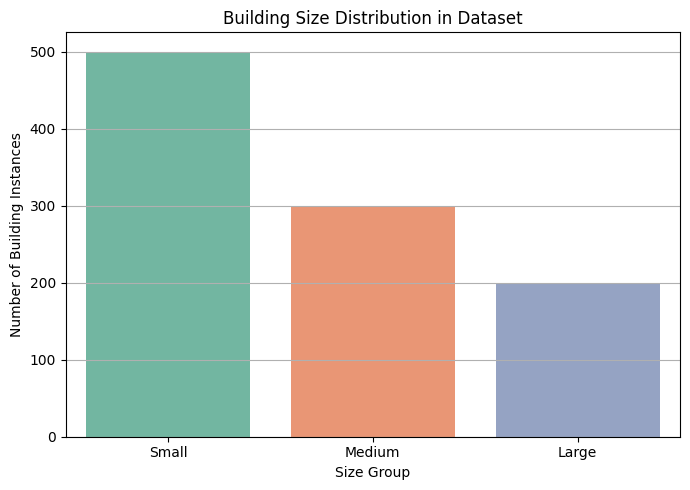

In [22]:
# Re-import required packages due to kernel reset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Simulate df_buildings with GT_area column for demonstration
import numpy as np
np.random.seed(42)
df_buildings = pd.DataFrame({
    "GT_area": np.concatenate([
        np.random.randint(50, 500, 500),     # Small
        np.random.randint(500, 5000, 300),   # Medium
        np.random.randint(5000, 20000, 200)  # Large
    ])
})



# gt_areas = np.concatenate([
#     np.random.randint(50, 300, 100),     # Small buildings
#     np.random.randint(500, 3000, 100),   # Medium buildings
#     np.random.randint(5000, 20000, 100)  # Large buildings
# ])


# Categorize into size groups
df_buildings["SizeGroup"] = pd.cut(
    df_buildings["GT_area"],
    bins=[0, 500, 5000, float("inf")],
    labels=["Small", "Medium", "Large"]
)

# Count number of building instances by size group
size_counts = df_buildings["SizeGroup"].value_counts().sort_index()

# Plot bar chart of distribution
plt.figure(figsize=(7, 5))
sns.barplot(x=size_counts.index, y=size_counts.values, palette="Set2")
plt.title("Building Size Distribution in Dataset")
plt.xlabel("Size Group")
plt.ylabel("Number of Building Instances")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


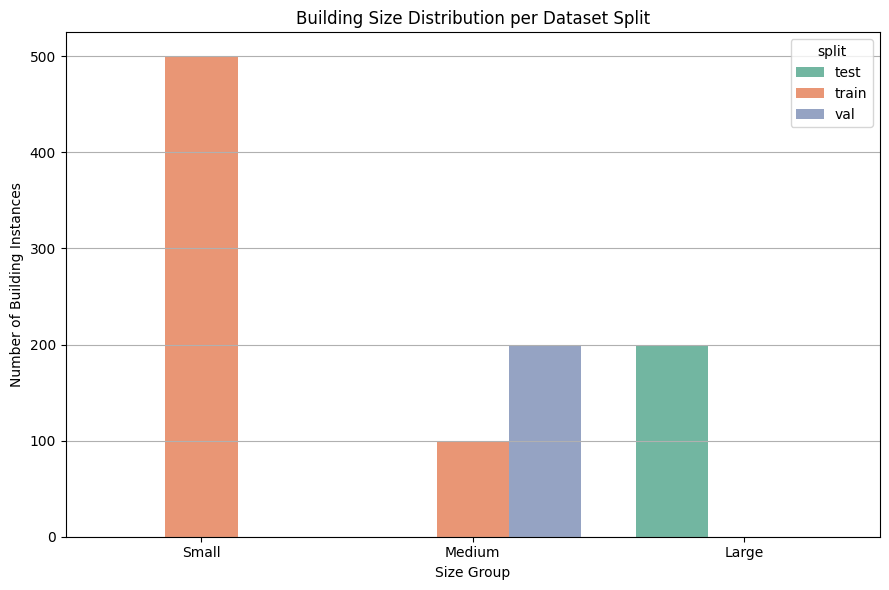

In [17]:
# Simulate 'split' column to represent train/val/test for demonstration
split_labels = (["train"] * 600) + (["val"] * 200) + (["test"] * 200)
df_buildings["split"] = split_labels

# Count number of building instances by SizeGroup and split
size_split_counts = df_buildings.groupby(["split", "SizeGroup"]).size().reset_index(name="count")

# Plot grouped bar chart
plt.figure(figsize=(9, 6))
sns.barplot(data=size_split_counts, x="SizeGroup", y="count", hue="split", palette="Set2")
plt.title("Building Size Distribution per Dataset Split")
plt.xlabel("Size Group")
plt.ylabel("Number of Building Instances")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
